In [64]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import itertools
import time
import numpy as np

In [38]:
df = pd.read_csv('data/latest_data.csv',index_col='Unnamed: 0')
df.head()

/Users/laurentvanhassel/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,backers_count,category,country_displayable_name,created_at,deadline,goal,launched_at,pledged,staff_pick,state,...,sub_category,blurb_length,launch_to_deadline,creation_to_launch,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,3,food,the United States,2014-08-30 01:10:21,2014-10-02 15:44:07,400.0,2014-09-02 15:44:07,15.0,False,failed,...,small batch,28.0,30,3,Tuesday,Thursday,September,October,2pm-4pm,2pm-4pm
1,6,technology,the United Kingdom,2015-02-18 17:15:56,2015-03-20 20:59:26,200.0,2015-02-18 21:59:26,28.0,False,failed,...,software,22.0,29,0,Wednesday,Friday,February,March,8pm-10pm,8pm-10pm
2,90,photography,the United States,2018-07-28 02:07:21,2018-08-27 13:18:38,2500.0,2018-07-28 13:18:38,4350.0,False,successful,...,photobooks,18.0,30,0,Saturday,Monday,July,August,12pm-2pm,12pm-2pm
3,205,photography,the United Kingdom,2018-02-10 14:42:07,2018-04-05 06:42:32,9500.0,2018-03-06 07:42:32,10181.0,False,successful,...,photobooks,19.0,29,23,Tuesday,Thursday,March,April,6am-8am,6am-8am
4,35,art,the United States,2012-07-25 23:21:04,2012-09-11 03:59:00,4000.0,2012-08-27 20:40:13,4254.0,False,successful,...,public art,25.0,14,32,Monday,Tuesday,August,September,8pm-10pm,2am-4am


In [39]:
df = df.drop(columns=['created_at', 'deadline','launched_at'])

In [40]:
df = df[df.goal >= 1000]

In [41]:
df.describe()

,backers_count,goal,pledged,usd_pledged,blurb_length,launch_to_deadline,creation_to_launch
count,1.940779e+06,1.940779e+06,1.940779e+06,1.940779e+06,1.940779e+06,1.940779e+06,1.940779e+06
mean,1.832457e+02,5.641188e+04,2.990736e+04,1.712284e+04,1.846870e+01,3.333216e+01,5.301180e+01
std,1.052678e+03,1.265638e+06,9.758207e+05,1.216304e+05,5.234429e+00,1.160738e+01,1.440875e+02
min,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.000000e+00,3.000000e+03,1.940000e+02,1.760000e+02,1.600000e+01,3.000000e+01,3.000000e+00
50%,4.000000e+01,6.100000e+03,3.011000e+03,2.880000e+03,2.000000e+01,3.000000e+01,1.300000e+01
75%,1.160000e+02,1.800000e+04,1.025519e+04,9.561894e+03,2.200000e+01,3.500000e+01,4.200000e+01
max,1.058570e+05,1.000000e+08,4.816218e+08,1.296961e+07,3.500000e+01,9.700000e+01,3.303000e+03


In [42]:
df.state.count()

1940779

In [43]:
df['state'].value_counts()

successful    1146167
failed         794612
Name: state, dtype: int64

In [44]:
df

,backers_count,category,country_displayable_name,goal,pledged,staff_pick,state,usd_pledged,sub_category,blurb_length,launch_to_deadline,creation_to_launch,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
Unnamed: 0,,,,,,,,,,,,,,,,,,
2,90,photography,the United States,2500.0,4350.0,False,successful,4350.000000,photobooks,18.0,30,0,Saturday,Monday,July,August,12pm-2pm,12pm-2pm
3,205,photography,the United Kingdom,9500.0,10181.0,False,successful,14043.223538,photobooks,19.0,29,23,Tuesday,Thursday,March,April,6am-8am,6am-8am
4,35,art,the United States,4000.0,4254.0,False,successful,4254.000000,public art,25.0,14,32,Monday,Tuesday,August,September,8pm-10pm,2am-4am
7,15,technology,the United States,50000.0,2423.5,False,failed,2423.500000,software,18.0,30,4,Friday,Sunday,July,August,4pm-6pm,4pm-6pm
8,69,photography,France,2250.0,2720.0,False,successful,3045.571597,photobooks,26.0,30,5,Monday,Wednesday,June,July,4pm-6pm,4pm-6pm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546506,36,music,the United States,2000.0,2319.0,False,successful,2319.000000,rock,17.0,30,426,Saturday,Monday,January,February,2am-4am,2am-4am
2546507,2,technology,the United Kingdom,10000.0,51.0,False,failed,66.865340,space exploration,23.0,30,1,Tuesday,Thursday,December,January,4pm-6pm,4pm-6pm
2546510,175,music,the United States,10000.0,10260.0,False,successful,10260.000000,jazz,18.0,31,106,Monday,Thursday,May,June,6pm-8pm,6pm-8pm


In [45]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np

In [46]:
cate_counts = df.launch_time.value_counts()
cate_counts

4pm-6pm      281907
2pm-4pm      252019
6pm-8pm      240798
8pm-10pm     214001
10pm-12am    184635
12pm-2pm     159682
12am-2am     146048
2am-4am      114976
4am-6am      101477
10am-12pm     90558
6am-8am       80503
8am-10am      74175
Name: launch_time, dtype: int64

In [47]:
df.dtypes

backers_count                 int64
category                     object
country_displayable_name     object
goal                        float64
pledged                     float64
staff_pick                     bool
state                        object
usd_pledged                 float64
sub_category                 object
blurb_length                float64
launch_to_deadline            int64
creation_to_launch            int64
launch_day                   object
deadline_day                 object
launch_month                 object
deadline_month               object
launch_time                  object
deadline_time                object
dtype: object

In [48]:
# need to convert bool to str
df['staff_pick'] = df['staff_pick'].astype(str)
df

,backers_count,category,country_displayable_name,goal,pledged,staff_pick,state,usd_pledged,sub_category,blurb_length,launch_to_deadline,creation_to_launch,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
Unnamed: 0,,,,,,,,,,,,,,,,,,
2,90,photography,the United States,2500.0,4350.0,False,successful,4350.000000,photobooks,18.0,30,0,Saturday,Monday,July,August,12pm-2pm,12pm-2pm
3,205,photography,the United Kingdom,9500.0,10181.0,False,successful,14043.223538,photobooks,19.0,29,23,Tuesday,Thursday,March,April,6am-8am,6am-8am
4,35,art,the United States,4000.0,4254.0,False,successful,4254.000000,public art,25.0,14,32,Monday,Tuesday,August,September,8pm-10pm,2am-4am
7,15,technology,the United States,50000.0,2423.5,False,failed,2423.500000,software,18.0,30,4,Friday,Sunday,July,August,4pm-6pm,4pm-6pm
8,69,photography,France,2250.0,2720.0,False,successful,3045.571597,photobooks,26.0,30,5,Monday,Wednesday,June,July,4pm-6pm,4pm-6pm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546506,36,music,the United States,2000.0,2319.0,False,successful,2319.000000,rock,17.0,30,426,Saturday,Monday,January,February,2am-4am,2am-4am
2546507,2,technology,the United Kingdom,10000.0,51.0,False,failed,66.865340,space exploration,23.0,30,1,Tuesday,Thursday,December,January,4pm-6pm,4pm-6pm
2546510,175,music,the United States,10000.0,10260.0,False,successful,10260.000000,jazz,18.0,31,106,Monday,Thursday,May,June,6pm-8pm,6pm-8pm


In [49]:
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

In [50]:
# Generate our categorical variable list
df_object = df.dtypes[df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
df[df_object].nunique()
# we can see that NAME, APPLICATION_TYPE, CLASSIFICATION will all be issues



category                     15
country_displayable_name     22
staff_pick                    2
sub_category                147
launch_day                    7
deadline_day                  7
launch_month                 12
deadline_month               12
launch_time                  12
deadline_time                12
dtype: int64

In [51]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[df_object]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(df_object)
encode_df.head()

,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,...,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_object,1)
df.head()

,backers_count,goal,pledged,state,usd_pledged,blurb_length,launch_to_deadline,creation_to_launch,category_art,category_comics,...,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
2,90,2500.0,4350.0,1,4350.000000,18.0,30,0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,205,9500.0,10181.0,1,14043.223538,19.0,29,23,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,35,4000.0,4254.0,1,4254.000000,25.0,14,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,15,50000.0,2423.5,0,2423.500000,18.0,30,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,69,2250.0,2720.0,1,3045.571597,26.0,30,5,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Split our preprocessed data into our features and target arrays
y = df["state"].values
X = df.drop(["state"],1).values


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [54]:
# Preprocess numerical data for neural network

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [55]:
len(X_train_scaled[0])

255

In [56]:
# Define the model - deep neural net
#inputs = 40
#layer one = 80 (2x inputs)
#layer two = 12
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
34630/34630 [==============================] - 22s 624us/step - loss: 0.2853 - accuracy: 0.8809
Epoch 2/50
34630/34630 [==============================] - 21s 595us/step - loss: 0.2058 - accuracy: 0.9220
Epoch 3/50
34630/34630 [==============================] - 21s 599us/step - loss: 0.1753 - accuracy: 0.9338
Epoch 4/50
34630/34630 [==============================] - 21s 610us/step - loss: 0.1509 - accuracy: 0.9434
Epoch 5/50
34630/34630 [==============================] - 21s 608us/step - loss: 0.1365 - accuracy: 0.9489
Epoch 6/50
34630/34630 [==============================] - 21s 605us/step - loss: 0.1270 - accuracy: 0.9528
Epoch 7/50
34630/34630 [==============================] - 21s 599us/step - loss: 0.1200 - accuracy: 0.9553
Epoch 8/50
34630/34630 [==============================] - 21s 598us/step - loss: 0.1137 - accuracy: 0.9580
Epoch 9/50
34630/34630 [==============================] - 21s 599us/step - loss: 0.1090 - accuracy: 0.9599
Epoch 10/50
34630/34630 [============

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

11544/11544 - 4s - loss: 0.0610 - accuracy: 0.9785
Loss: 0.060961417853832245, Accuracy: 0.978458821773529


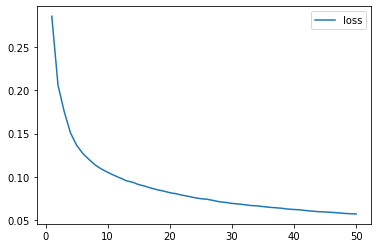

In [58]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

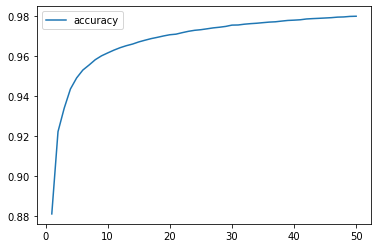

In [59]:
# Plot the loss
history_df.plot(y="accuracy")

In [60]:
# Define the logistic regression model
log_classifier = LogisticRegression(solver="lbfgs",max_iter=200)

# Train the model
log_classifier.fit(X_train,y_train)

# Evaluate the model
y_pred = log_classifier.predict(X_test)
print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

/Users/laurentvanhassel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Logistic regression model accuracy: 1.000


In [61]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.993


In [62]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([2.11546797e-01, 9.74921214e-02, 3.36935146e-01, 2.57202471e-01,
       6.14545436e-03, 1.27030743e-02, 2.27720183e-02, 3.64033933e-04,
       2.55002143e-04, 2.10987425e-04, 1.90037694e-04, 2.49158424e-04,
       2.56150809e-04, 4.76475070e-04, 3.82592780e-04, 3.00478490e-04,
       2.05753118e-04, 4.57614369e-04, 2.44280129e-04, 3.88972077e-04,
       4.38222221e-04, 2.39409877e-04, 2.44662813e-04, 5.98977954e-05,
       6.16803548e-05, 3.71994656e-04, 9.55950257e-05, 1.75056839e-04,
       2.02196689e-04, 1.19531213e-04, 5.88114987e-05, 1.62096686e-04,
       6.50132832e-05, 1.21885722e-05, 1.98666448e-04, 8.40511338e-05,
       6.15551109e-05, 7.34779387e-05, 1.49036902e-04, 1.28750971e-04,
       7.60611076e-05, 1.42835788e-04, 5.59135381e-04, 8.93813821e-04,
       6.16915366e-04, 6.26420643e-04, 8.30820624e-05, 9.38847930e-05,
       1.07789128e-04, 7.39382786e-05, 4.26707217e-05, 1.61179313e-04,
       1.13603245e-04, 1.49241462e-04, 1.55165278e-04, 7.98493579e-05,
      

In [68]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'